In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
import numpy as np

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Fashion-MNIST preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Download and load Fashion-MNIST
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Fashion-MNIST classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {classes}")


100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.26MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 50.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.4MB/s]


Training samples: 60000
Test samples: 10000
Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [4]:
class TeacherCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(TeacherCNN, self).__init__()
        # Large feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Large classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 3 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [5]:
def train_model(model, train_loader, num_epochs, learning_rate, device):
    """Standard training function for any CNN model"""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}')

    return train_losses


In [6]:
def test_model(model, test_loader, device):
    """Test model accuracy"""
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train Teacher Model
print("Training Teacher Model...")
teacher_model = TeacherCNN(num_classes=10)
teacher_losses = train_model(teacher_model, train_loader, num_epochs=5, learning_rate=0.001, device=device)
teacher_accuracy = test_model(teacher_model, test_loader, device)
teacher_params = count_parameters(teacher_model)
print(f"Teacher model parameters: {teacher_params:,}")


Training Teacher Model...
Epoch [1/5], Step [100/469], Loss: 0.7271
Epoch [1/5], Step [200/469], Loss: 0.4466
Epoch [1/5], Step [300/469], Loss: 0.5856
Epoch [1/5], Step [400/469], Loss: 0.3492
Epoch [1/5] completed, Average Loss: 0.6623
Epoch [2/5], Step [100/469], Loss: 0.3166
Epoch [2/5], Step [200/469], Loss: 0.3386
Epoch [2/5], Step [300/469], Loss: 0.3550
Epoch [2/5], Step [400/469], Loss: 0.3348
Epoch [2/5] completed, Average Loss: 0.3312
Epoch [3/5], Step [100/469], Loss: 0.4238
Epoch [3/5], Step [200/469], Loss: 0.2069
Epoch [3/5], Step [300/469], Loss: 0.2236
Epoch [3/5], Step [400/469], Loss: 0.3767
Epoch [3/5] completed, Average Loss: 0.2765
Epoch [4/5], Step [100/469], Loss: 0.2557
Epoch [4/5], Step [200/469], Loss: 0.2267
Epoch [4/5], Step [300/469], Loss: 0.2331
Epoch [4/5], Step [400/469], Loss: 0.2446
Epoch [4/5] completed, Average Loss: 0.2429
Epoch [5/5], Step [100/469], Loss: 0.1762
Epoch [5/5], Step [200/469], Loss: 0.1453
Epoch [5/5], Step [300/469], Loss: 0.1847


In [7]:
class StudentCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentCNN, self).__init__()
        # Small feature extractor - much fewer channels
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Small classifier - fewer parameters
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [8]:
def distillation_loss(student_logits, teacher_logits, labels, temperature=3.0, alpha=0.7):
    """
    Compute the knowledge distillation loss combining soft and hard targets
    Args:
        student_logits: Raw outputs from student model
        teacher_logits: Raw outputs from teacher model
        labels: True labels
        temperature: Temperature for softening probability distributions
        alpha: Weight for distillation loss vs hard target loss
    """
    # Soft targets from teacher (knowledge transfer)
    teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
    student_log_probs = F.log_softmax(student_logits / temperature, dim=1)

    # Distillation loss (KL divergence) - learns from teacher
    distill_loss = F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (temperature ** 2)

    # Hard target loss - learns from ground truth
    hard_loss = F.cross_entropy(student_logits, labels)

    # Combined loss - balance both learning objectives
    total_loss = alpha * distill_loss + (1 - alpha) * hard_loss

    return total_loss


In [9]:
def train_student_with_distillation(student_model, teacher_model, train_loader, num_epochs, learning_rate, device, temperature=3.0, alpha=0.7):
    """Train student model using knowledge distillation"""
    student_model.to(device)
    teacher_model.to(device)

    # Set teacher to evaluation mode (no gradients needed)
    teacher_model.eval()
    student_model.train()

    optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Get teacher outputs (no gradients needed)
            with torch.no_grad():
                teacher_logits = teacher_model(inputs)

            # Get student outputs and train
            optimizer.zero_grad()
            student_logits = student_model(inputs)

            # Calculate distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels, temperature, alpha)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 100 == 99:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}')

    return train_losses


In [10]:
# Train baseline student (without distillation)
print("\nTraining Student Model WITHOUT Distillation...")
student_baseline = StudentCNN(num_classes=10)
baseline_losses = train_model(student_baseline, train_loader, num_epochs=5, learning_rate=0.001, device=device)
baseline_accuracy = test_model(student_baseline, test_loader, device)

# Train distilled student (with knowledge distillation)
print("\nTraining Student Model WITH Knowledge Distillation...")
student_distilled = StudentCNN(num_classes=10)
distill_losses = train_student_with_distillation(
    student_distilled, teacher_model, train_loader,
    num_epochs=5, learning_rate=0.001, device=device,
    temperature=3.0, alpha=0.7
)
distilled_accuracy = test_model(student_distilled, test_loader, device)

student_params = count_parameters(student_baseline)
print(f"Student model parameters: {student_params:,}")



Training Student Model WITHOUT Distillation...
Epoch [1/5], Step [100/469], Loss: 0.5788
Epoch [1/5], Step [200/469], Loss: 0.5030
Epoch [1/5], Step [300/469], Loss: 0.4255
Epoch [1/5], Step [400/469], Loss: 0.3276
Epoch [1/5] completed, Average Loss: 0.5577
Epoch [2/5], Step [100/469], Loss: 0.4028
Epoch [2/5], Step [200/469], Loss: 0.3909
Epoch [2/5], Step [300/469], Loss: 0.2859
Epoch [2/5], Step [400/469], Loss: 0.4887
Epoch [2/5] completed, Average Loss: 0.3423
Epoch [3/5], Step [100/469], Loss: 0.4053
Epoch [3/5], Step [200/469], Loss: 0.2878
Epoch [3/5], Step [300/469], Loss: 0.1703
Epoch [3/5], Step [400/469], Loss: 0.2912
Epoch [3/5] completed, Average Loss: 0.2959
Epoch [4/5], Step [100/469], Loss: 0.1935
Epoch [4/5], Step [200/469], Loss: 0.2179
Epoch [4/5], Step [300/469], Loss: 0.2524
Epoch [4/5], Step [400/469], Loss: 0.2450
Epoch [4/5] completed, Average Loss: 0.2667
Epoch [5/5], Step [100/469], Loss: 0.2429
Epoch [5/5], Step [200/469], Loss: 0.3343
Epoch [5/5], Step [3

In [11]:
def measure_inference_time(model, test_loader, device, num_batches=50):
    """Measure average inference time per batch"""
    model.to(device)
    model.eval()

    times = []
    with torch.no_grad():
        for i, (inputs, _) in enumerate(test_loader):
            if i >= num_batches:
                break

            inputs = inputs.to(device)

            start_time = time.time()
            _ = model(inputs)
            torch.cuda.synchronize()  # Wait for GPU operations to complete
            end_time = time.time()

            times.append(end_time - start_time)

    avg_time = np.mean(times) * 1000  # Convert to milliseconds
    return avg_time

# Measure inference times
teacher_time = measure_inference_time(teacher_model, test_loader, device)
student_baseline_time = measure_inference_time(student_baseline, test_loader, device)
student_distilled_time = measure_inference_time(student_distilled, test_loader, device)

# Calculate model sizes (approximate)
teacher_size = teacher_params * 4 / (1024**2)  # Assuming 32-bit floats, convert to MB
student_size = student_params * 4 / (1024**2)


In [12]:
print("\n" + "="*60)
print("KNOWLEDGE DISTILLATION RESULTS SUMMARY")
print("="*60)

print(f"\nMODEL ACCURACY:")
print(f"Teacher Model:           {teacher_accuracy:.2f}%")
print(f"Student (Baseline):      {baseline_accuracy:.2f}%")
print(f"Student (Distilled):     {distilled_accuracy:.2f}%")
print(f"Improvement:             {distilled_accuracy - baseline_accuracy:.2f}%")

print(f"\nMODEL SIZE:")
print(f"Teacher Parameters:      {teacher_params:,}")
print(f"Student Parameters:      {student_params:,}")
print(f"Size Reduction:          {teacher_params/student_params:.1f}x smaller")
print(f"Teacher Size:            {teacher_size:.1f} MB")
print(f"Student Size:            {student_size:.1f} MB")

print(f"\nINFERENCE SPEED (per batch):")
print(f"Teacher Model:           {teacher_time:.2f} ms")
print(f"Student (Baseline):      {student_baseline_time:.2f} ms")
print(f"Student (Distilled):     {student_distilled_time:.2f} ms")
print(f"Speed Improvement:       {teacher_time/student_distilled_time:.1f}x faster")

print(f"\nKEY INSIGHTS:")
print(f"• Student model is {teacher_params/student_params:.1f}x smaller than teacher")
print(f"• Student model is {teacher_time/student_distilled_time:.1f}x faster than teacher")
print(f"• Knowledge distillation improved student accuracy by {distilled_accuracy - baseline_accuracy:.2f}%")
print(f"• Only {teacher_accuracy - distilled_accuracy:.2f}% accuracy loss vs teacher with major efficiency gains")



KNOWLEDGE DISTILLATION RESULTS SUMMARY

MODEL ACCURACY:
Teacher Model:           91.43%
Student (Baseline):      90.91%
Student (Distilled):     89.32%
Improvement:             -1.59%

MODEL SIZE:
Teacher Parameters:      9,823,626
Student Parameters:      390,410
Size Reduction:          25.2x smaller
Teacher Size:            37.5 MB
Student Size:            1.5 MB

INFERENCE SPEED (per batch):
Teacher Model:           18.65 ms
Student (Baseline):      1.56 ms
Student (Distilled):     1.60 ms
Speed Improvement:       11.7x faster

KEY INSIGHTS:
• Student model is 25.2x smaller than teacher
• Student model is 11.7x faster than teacher
• Knowledge distillation improved student accuracy by -1.59%
• Only 2.11% accuracy loss vs teacher with major efficiency gains


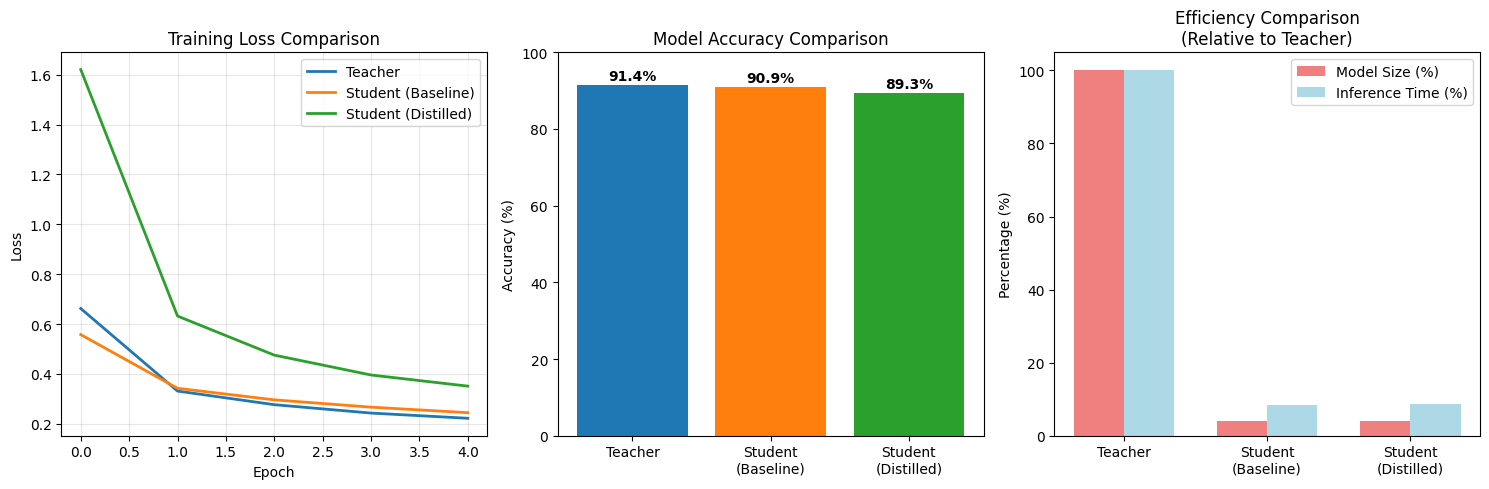


Models saved successfully!


In [13]:
plt.figure(figsize=(15, 5))

# Plot 1: Training losses
plt.subplot(1, 3, 1)
plt.plot(teacher_losses, label='Teacher', linewidth=2)
plt.plot(baseline_losses, label='Student (Baseline)', linewidth=2)
plt.plot(distill_losses, label='Student (Distilled)', linewidth=2)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy comparison
plt.subplot(1, 3, 2)
models = ['Teacher', 'Student\n(Baseline)', 'Student\n(Distilled)']
accuracies = [teacher_accuracy, baseline_accuracy, distilled_accuracy]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: Efficiency comparison
plt.subplot(1, 3, 3)
x = np.arange(len(models))
width = 0.35

# Normalize for visualization (teacher = 100%)
size_norm = [100, student_params/teacher_params*100, student_params/teacher_params*100]
speed_norm = [100, student_baseline_time/teacher_time*100, student_distilled_time/teacher_time*100]

bars1 = plt.bar(x - width/2, size_norm, width, label='Model Size (%)', color='lightcoral')
bars2 = plt.bar(x + width/2, speed_norm, width, label='Inference Time (%)', color='lightblue')

plt.title('Efficiency Comparison\n(Relative to Teacher)')
plt.ylabel('Percentage (%)')
plt.xticks(x, models)
plt.legend()

plt.tight_layout()
plt.show()

# Save models for submission
torch.save(teacher_model.state_dict(), 'teacher_model.pth')
torch.save(student_distilled.state_dict(), 'student_distilled_model.pth')
print("\nModels saved successfully!")
